In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed = 42 #424
np.random.seed(seed)
torch.manual_seed(seed)
#NOTE! This only works for non cudnn. gpu needs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from bayes_opt import BayesianOptimization



from helpers import showcase_code
from measures import compute_error

import itertools

In [47]:
showcase = True
toy = True

# parameter search

1. Bayesian optimization
2. to ensure comparability, we only optimize the simple model that is the base for all the ensembles
3. Optimize once for toy and once for kaggle dataset
4. parameters to optimize:
5. function to be optimized: "an objective function ceases to be a good measuerement of success when it's used as optimization target" or something like that. So we're happy to optimize for error while we're actually interested in things like cobeau and nlpd!






In [48]:

from nn_models.base_model import SimpleModel
showcase_code('nn_models/base_model.py','SimpleModel',showcase)


## toy model optimisation


In [49]:
from data_loaders import get_X_y, generate_y
#showcase_code('data_loaders.py')


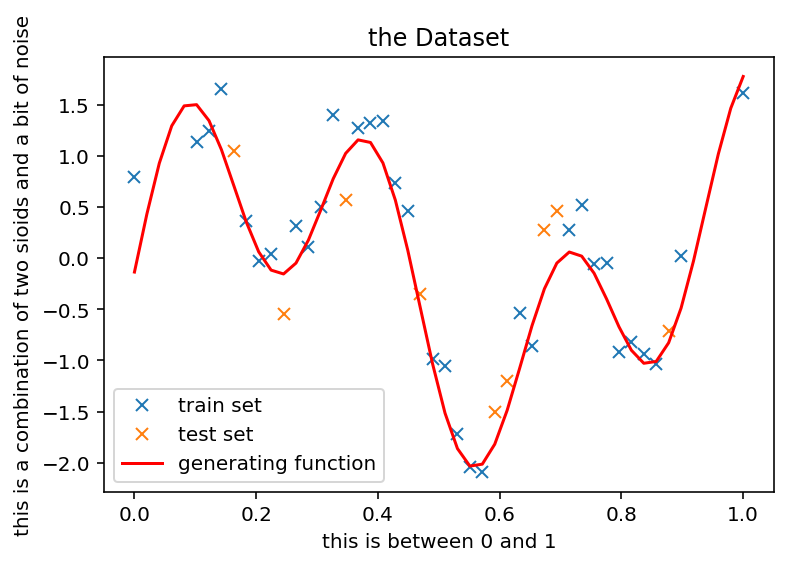

In [50]:
X_train, X_test, y_train, y_test, N, output_dims  = get_X_y(toy,seed=seed)

In [51]:
X_train.shape

(33, 1)

In [52]:
y_train.shape

(33, 1)

In [53]:
def black_box_function(model_provided, decay, num_epochs=500):
    model = SimpleModel(toy,X_train.shape[1], p=0.0, model_provided=model_provided, decay=decay)
    #model.to(device)
    
    losses = []
    for i in range(num_epochs):
        losses.append(model.fit_model(X_train,y_train))
        
    y_pred = model(X_test).data.numpy()
    
    
    #plt.plot(X_test,y_test,'x')
    #plt.plot(X_test,y_pred,'x')
    #plt.plot(losses)
    #plt.show()
    
    return compute_error(y_test,y_pred)



In [54]:
%%time
#black_box_function(torch.nn.ReLU,0.001)

Wall time: 0 ns


In [55]:
%%time
#black_box_function(torch.nn.LeakyReLU,0.001)

Wall time: 0 ns


In [56]:
non_linearities = [torch.nn.LeakyReLU, torch.nn.ReLU]

# models = 

def make_models(n_dims_input, non_linearity, layer_tuples):
                
        
    layers_list = [[torch.nn.Linear(*layer_tuple), non_linearity()] for layer_tuple in layer_tuples] + [[torch.nn.Dropout(p=0),
    torch.nn.Linear(layer_tuples[-1][1],1)]]
    layers_list = list(itertools.chain.from_iterable(layers_list))

    
    return torch.nn.Sequential(
    torch.nn.Linear(n_dims_input,layer_tuples[0][0]),
    non_linearity(),
        
        
        
    *layers_list
        

    )
    
    #return layers_list

In [57]:
layer_tuple_list = [#[(10,10)],
                    #[(20,20),(20,10),(10,10)],
                    #[(20,10),(10,10),(10,10),(10,10)],
                    #[(20,50),(50,5),(5,10)],
                    [(20,50),(50,25),(25,10),(10,5),(5,3)],
                    #[(10,10),(10,50),(50,10)],
                    [(100,100),(100,10)],
                    [(100,100),(100,100),(100,10)],
    [(500,300),(300,200),(200,10)]
                    ]

In [66]:
pbounds = {'layers':layer_tuple_list, 
           'decays': np.linspace(0.0005,0.05,10),
           'non_linearities':[torch.nn.LeakyReLU, torch.nn.ReLU, torch.nn.Tanh, torch.nn.Sigmoid]
          }
#pbounds = { 'decay': (0.0005,0.005)}
seeds = np.array([1, 3, 42, 69, 420, 100, 2,4,5,6])*1000000

In [67]:
pbounds['decays']

array([0.0005  , 0.012875, 0.02525 , 0.037625, 0.05    ])

In [69]:
%%time
np.random.seed(0)
torch.manual_seed(0)

outcome_list = []


# run the optimization on small net to see if somethings wrong
seed_outcomes = []
for seed in seeds:
    decay = 0.005
    dumb_network = make_models(X_train.shape[1],torch.nn.LeakyReLU, [(1,1)])
    #dumb_network.to(device)
    seed_outcomes.append(black_box_function(dumb_network,decay))



outcome_mean = np.mean(seed_outcomes)
outcome_std = np.std(seed_outcomes)
outcome_dict = {'params':{'model':dumb_network,'decay':decay},
                     'stats':{'outcome_mean':outcome_mean,'outcome_std':outcome_std}
                    }

print(f'dumb net results: {outcome_dict}')
outcome_list.append(outcome_dict)


num_models = len(pbounds['layers']) * len(pbounds['decays']) * len(pbounds['non_linearities'])
print(f'testing {num_models} models')


i = 0
#append the actual gridsearch
for decay in pbounds['decays']:
    print(decay)
    for layers in pbounds['layers']:
        print(layers)
        for non_linearity in pbounds['non_linearities']:
            print(non_linearity)
            i+=1
            print(f'model #{i} of {num_models}')
            seed_outcomes = []
            for seed in seeds:
                
                X_train, X_test, y_train, y_test, N, output_dims  = get_X_y(toy,seed=seed,out_of_sample=False)
                np.random.seed(seed)
                torch.manual_seed(seed) 
                
                #make_models(X_train.shape[1],torch.nn.LeakyReLU, [(1,1)])
                model = make_models(X_train.shape[1],non_linearity,layers)
                #model.to(device)

                seed_outcomes.append(black_box_function(model,decay))
                        
            outcome_mean = np.mean(seed_outcomes)
            outcome_std = np.std(seed_outcomes)
            outcome_dict = {'params':{'model':model,'decay':decay},
                                 'stats':{'outcome_mean':outcome_mean,'outcome_std':outcome_std}
                                }
            outcome_list.append(outcome_dict)
            #print(outcome_dict)

            print(f'{np.mean(seed_outcomes), np.std(seed_outcomes)}')


dumb net results: {'params': {'model': Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Dropout(p=0, inplace=False)
  (5): Linear(in_features=1, out_features=1, bias=True)
), 'decay': 0.005}, 'stats': {'outcome_mean': 0.8116386283047744, 'outcome_std': 0.09000147889345464}}
testing 80 models
0.0005
[(20, 50), (50, 25), (25, 10), (10, 5), (5, 3)]
<class 'torch.nn.modules.activation.LeakyReLU'>
model #1 of 80
(0.6419461863718914, 0.15249821486649717)
<class 'torch.nn.modules.activation.ReLU'>
model #2 of 80
(0.5952987359268175, 0.19195652697821633)
<class 'torch.nn.modules.activation.Tanh'>
model #3 of 80
(0.48886367435639927, 0.13552005274490966)
<class 'torch.nn.modules.activation.Sigmoid'>
model #4 of 80
(0.7974879553367729, 0.16748339178322075)
[(100, 100), (100, 10)]
<class 'torch.nn.modules.activation.LeakyReLU'>
model #5 of 8

ValueError: Image size of 768x69687 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [99]:
model

Sequential(
  (0): Linear(in_features=1, out_features=500, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=500, out_features=300, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=300, out_features=200, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=200, out_features=10, bias=True)
  (7): Sigmoid()
  (8): Dropout(p=0, inplace=False)
  (9): Linear(in_features=10, out_features=1, bias=True)
)

In [100]:
non_linearity

torch.nn.modules.activation.Sigmoid

In [101]:
# %%time

# outcome_list = []
# for seed in seeds:
#     np.random.seed(seed)
#     torch.manual_seed(seed) 
    
#     models =  [make_models(X_train.shape[1],torch.nn.LeakyReLU, [(1,1)]), make_models(X_train.shape[1],torch.nn.LeakyReLU, [(10,10)])] + models
    
#     for model in pbounds['model_provided']:
#         print(model)
#         seed_outcomes = []

#         seed_outcomes.append(black_box_function(model,decay))

#         print(seed_outcomes)


#         outcome_mean = np.mean(seed_outcomes)
#         outcome_std = np.std(seed_outcomes)
#         outcome_dict = {'params':{'model':model,'decay':decay},
#                              'stats':{'outcome_mean':outcome_mean,'outcome_std':outcome_std}
#                             }
#         outcome_list.append(outcome_dict)
#         #print(outcome_dict)

#         print(f'{np.mean(seed_outcomes), np.std(seed_outcomes)}')


In [102]:
#np.array(outcome_list)[index]

In [103]:
stats = [x['stats'] for x in outcome_list] 

In [104]:
means = [ x['outcome_mean'] for x in stats]
stds = [ x['outcome_std'] for x in stats]

<BarContainer object of 81 artists>

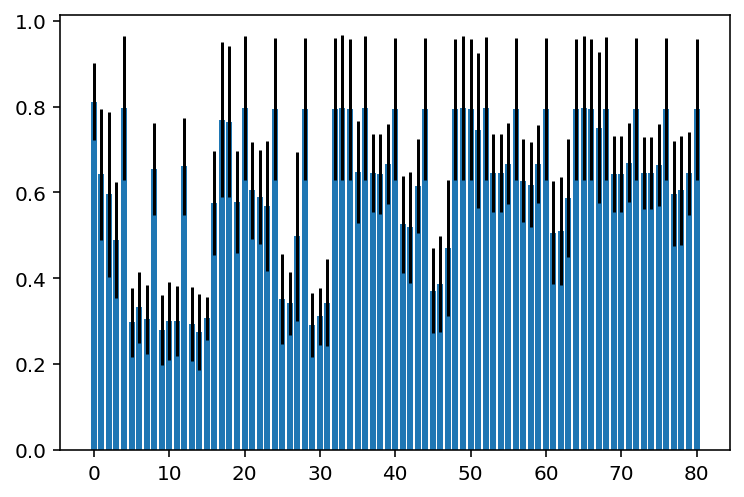

In [105]:
plt.bar(list(range(len(means))),means,yerr=stds)

In [106]:
index = np.argsort(means)

In [107]:
index

array([14,  9, 29, 13,  5, 11, 10,  7, 15, 30,  6, 26, 31, 25, 45, 46, 47,
        3, 27, 61, 62, 42, 41, 23, 16, 19, 63, 22,  2, 77, 21, 78, 43, 58,
       57,  1, 70, 69, 38, 53, 54, 79, 74, 37, 73, 35,  8, 12, 75, 59, 39,
       55, 71, 51, 67, 18, 17, 50, 34, 66, 80, 64, 48, 32, 76, 24, 60, 28,
       44, 40, 72, 56, 68, 52, 36, 20,  4, 65, 49, 33,  0], dtype=int64)

In [108]:
np.array(means)[index]

array([0.27339162, 0.27846752, 0.2908161 , 0.29285478, 0.29676541,
       0.30049412, 0.30089411, 0.30365252, 0.30597164, 0.31110452,
       0.33149279, 0.34092948, 0.34292044, 0.35023296, 0.37073683,
       0.38608058, 0.46985843, 0.48886367, 0.49725801, 0.50636821,
       0.51026935, 0.51882257, 0.52546117, 0.56817932, 0.57604521,
       0.57777159, 0.58767084, 0.58923669, 0.59529874, 0.59678636,
       0.60468041, 0.60468964, 0.6142039 , 0.61824753, 0.62731525,
       0.64194619, 0.6422213 , 0.6431072 , 0.64318014, 0.64447027,
       0.64473165, 0.64478725, 0.64498074, 0.6452579 , 0.64554798,
       0.64790731, 0.65462101, 0.66070125, 0.66448275, 0.66562642,
       0.66656532, 0.66732372, 0.66970183, 0.74482015, 0.75106411,
       0.76527236, 0.76997211, 0.79336354, 0.79338212, 0.79338637,
       0.79433717, 0.79435573, 0.79438174, 0.79442497, 0.79454675,
       0.79459601, 0.79460109, 0.79463876, 0.79464412, 0.79471748,
       0.7947241 , 0.79474248, 0.79568255, 0.7959604 , 0.79634

In [109]:
params = [x['params'] for x in outcome_list]

In [111]:
#params

In [112]:
np.array(stds)[index]

array([0.08846722, 0.08140319, 0.07512475, 0.0865697 , 0.08133385,
       0.08195635, 0.0911697 , 0.07960932, 0.05015161, 0.06647679,
       0.08226756, 0.07418154, 0.10149012, 0.10500736, 0.09882148,
       0.11243192, 0.15855226, 0.13552005, 0.19625938, 0.11933013,
       0.1266383 , 0.12928172, 0.1133447 , 0.15243242, 0.12118977,
       0.11939001, 0.13730564, 0.10895807, 0.19195653, 0.12220173,
       0.11240831, 0.12656549, 0.10987115, 0.09828746, 0.09636579,
       0.15249821, 0.08862902, 0.08955883, 0.09375384, 0.09092382,
       0.09118033, 0.09680427, 0.08306788, 0.09104711, 0.0841833 ,
       0.11841519, 0.10782952, 0.11318421, 0.09562459, 0.091231  ,
       0.09355274, 0.09515615, 0.0931551 , 0.1812566 , 0.17607842,
       0.17694223, 0.18091856, 0.16488107, 0.16478853, 0.16488393,
       0.16453738, 0.16455485, 0.16458047, 0.16463268, 0.1646396 ,
       0.16477699, 0.16467196, 0.1647418 , 0.16470799, 0.16479338,
       0.1647353 , 0.1647719 , 0.16741629, 0.16741651, 0.16745

In [113]:
np.array(params)[index][:5]

array([{'model': Sequential(
  (0): Linear(in_features=1, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=200, bias=True)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=10, bias=True)
  (7): ReLU()
  (8): Dropout(p=0, inplace=False)
  (9): Linear(in_features=10, out_features=1, bias=True)
), 'decay': 0.0005},
       {'model': Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=100, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Dropout(p=0, inplace=False)
  (9): Linear(in_features=10, out_features=1, bias=True)
), 'decay': 0.0005},
       {'model': Sequential(
  (0)

In [84]:
np.array(params)[index][0] 

{'model': Sequential(
   (0): Linear(in_features=1, out_features=500, bias=True)
   (1): ReLU()
   (2): Linear(in_features=500, out_features=300, bias=True)
   (3): ReLU()
   (4): Linear(in_features=300, out_features=200, bias=True)
   (5): ReLU()
   (6): Linear(in_features=200, out_features=10, bias=True)
   (7): ReLU()
   (8): Dropout(p=0, inplace=False)
   (9): Linear(in_features=10, out_features=1, bias=True)
 ), 'decay': 0.0005}

In [85]:
np.array(params)[index][1] 

{'model': Sequential(
   (0): Linear(in_features=1, out_features=100, bias=True)
   (1): LeakyReLU(negative_slope=0.01)
   (2): Linear(in_features=100, out_features=100, bias=True)
   (3): LeakyReLU(negative_slope=0.01)
   (4): Linear(in_features=100, out_features=100, bias=True)
   (5): LeakyReLU(negative_slope=0.01)
   (6): Linear(in_features=100, out_features=10, bias=True)
   (7): LeakyReLU(negative_slope=0.01)
   (8): Dropout(p=0, inplace=False)
   (9): Linear(in_features=10, out_features=1, bias=True)
 ), 'decay': 0.0005}

In [86]:
np.array(params)[index]

array([{'model': Sequential(
  (0): Linear(in_features=1, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=200, bias=True)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=10, bias=True)
  (7): ReLU()
  (8): Dropout(p=0, inplace=False)
  (9): Linear(in_features=10, out_features=1, bias=True)
), 'decay': 0.0005},
       {'model': Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=100, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Dropout(p=0, inplace=False)
  (9): Linear(in_features=10, out_features=1, bias=True)
), 'decay': 0.0005},
       {'model': Sequential(
  (0)

In [87]:
np.mean(means)

0.6126463605605013

In [88]:
    model_params = [[x.out_features for x in list(params[index]['model']) if hasattr(x,'out_features')]]


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
model_params

In [ ]:
np.array(params)[index]